In [8]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from pprint import pprint

In [2]:
data_dir = r"C:\Users\yrliu98\Desktop\2025_04_04_Cyerene_test"

txt_files = list(Path(data_dir).glob("*.txt"))

pprint(txt_files)

[WindowsPath('C:/Users/yrliu98/Desktop/2025_04_04_Cyerene_test/Cyrene_100C_front.txt'),
 WindowsPath('C:/Users/yrliu98/Desktop/2025_04_04_Cyerene_test/Cyrene_CB_back.txt'),
 WindowsPath('C:/Users/yrliu98/Desktop/2025_04_04_Cyerene_test/Cyrene_CB_front.txt'),
 WindowsPath('C:/Users/yrliu98/Desktop/2025_04_04_Cyerene_test/Cyrene_RT_front.txt'),
 WindowsPath('C:/Users/yrliu98/Desktop/2025_04_04_Cyerene_test/rac_ACN_front.txt')]


In [3]:
dfs = []
for txt_file in txt_files:
    df = pd.read_csv(
        txt_file,
        sep="\t",
        names=["wavelength", "CD", "HT", "abs"],
        skiprows=21,
        nrows=400,
    )
    dfs.append({"name": txt_file.stem, **df.to_dict(orient="list"), "df": df})

double_side_samples = [df["df"] for df in dfs if ("Cyrene_CB_" in df["name"])]

genuine_df = double_side_samples[0].merge(double_side_samples[1], on="wavelength")

genuine_df["genuine_CD"] = (genuine_df["CD_x"] + genuine_df["CD_y"]) / 2

genuine_df["avg_abs"] = (genuine_df["abs_x"] + genuine_df["abs_y"]) / 2

to_exclude = [0, 1, 2, 3]

for i in sorted(to_exclude, reverse=True):
    dfs.pop(i)

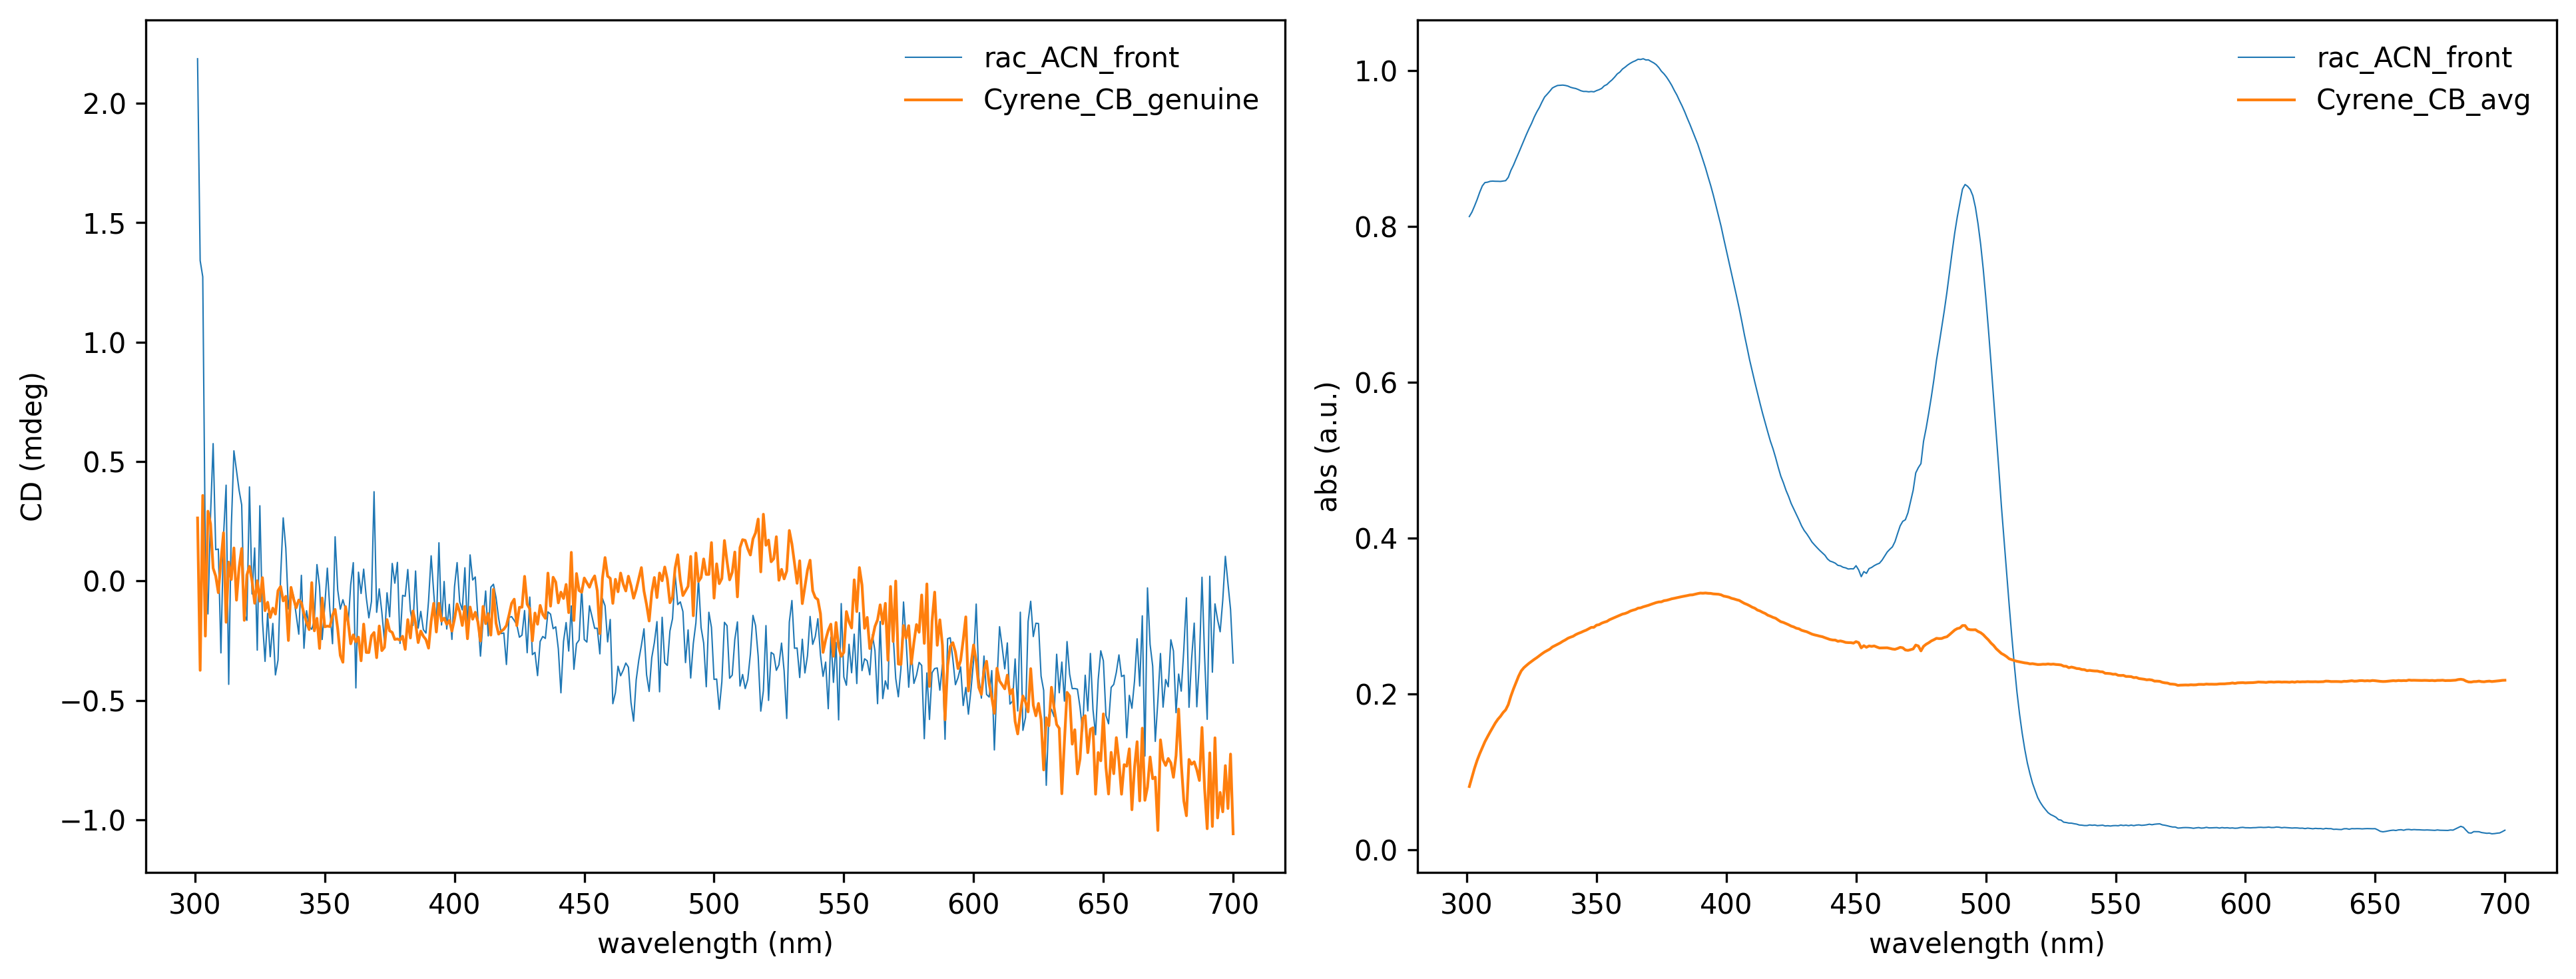

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), dpi=300, layout="tight")

for df in dfs:
    axs[0].plot(df["wavelength"], df["CD"], label=df["name"], lw=0.5)

axs[0].plot(
    genuine_df["wavelength"], genuine_df["genuine_CD"], label="Cyrene_CB_genuine", lw=1
)

handles, labels = axs[0].get_legend_handles_labels()
order = [4, 0, 3, 2, 1, 5]
if len(order) == len(dfs):
    axs[0].legend(
        [handles[idx] for idx in order], [labels[idx] for idx in order], frameon=False
    )
else:
    axs[0].legend(frameon=False)

axs[0].set_xlabel("wavelength (nm)")
axs[0].set_ylabel("CD (mdeg)")

for df in dfs:
    axs[1].plot(df["wavelength"], df["abs"], label=df["name"], lw=0.5)


axs[1].plot(
    genuine_df["wavelength"], genuine_df["avg_abs"], label="Cyrene_CB_avg", lw=1
)

axs[1].legend(frameon=False)
axs[1].set_xlabel("wavelength (nm)")
axs[1].set_ylabel("abs (a.u.)")
# axs[1].set_yscale("log")

fig.savefig(Path(data_dir, "ACN_CB_plot.jpg"))

In [7]:
data_dir = Path(r"G:\My Drive\CD\20250702_S_MeOMBAI")

txt_files = sorted(list(Path(data_dir).glob("*.csv")))

pprint(txt_files)

[]


In [8]:
dfs = []
common_cols = set()
for txt_file in txt_files:
    if "front" in txt_file.stem:
        get_col = lambda col: f"front_{col}_{txt_file.stem.replace('_front', '')}"
    elif "back" in txt_file.stem:
        get_col = lambda col: f"back_{col}_{txt_file.stem.replace('_back', '')}"
    else:
        raise ValueError(
            f"File {txt_file} does not contain 'front' or 'back' in its name."
        )

    common_cols.add(txt_file.stem.replace("_front", "").replace("_back", ""))

    df = pd.read_csv(
        txt_file,
        sep=",",
        names=["wavelength", get_col("CD"), get_col("HT"), get_col("abs")],
        skiprows=21,
        nrows=400,
    )
    df = df.set_index("wavelength")
    df = df[df.index < 550]
    # df = df[df.index > 470]
    dfs.append(df)

df = pd.concat(dfs, axis=1)

for common_col in sorted(common_cols):
    df[f"gen_CD_{common_col}"] = (
        df[f"front_CD_{common_col}"] + df[f"back_CD_{common_col}"]
    ) / 2
    df[f"ldlb_CD_{common_col}"] = (
        df[f"front_CD_{common_col}"] - df[f"back_CD_{common_col}"]
    )
    df[f"abs_{common_col}"] = (
        df[f"front_abs_{common_col}"] + df[f"back_abs_{common_col}"]
    ) / 2
    df[f"g_factor_{common_col}"] = df[f"gen_CD_{common_col}"] / (
        df[f"abs_{common_col}"] * 32980
    )


df.head()

ValueError: No objects to concatenate

In [ ]:
# def get_label(_name):
#     """Extract a clean label from column name."""
#     name = _name.replace("CD_", "").replace("HT_", "").replace("abs_", "")

#     if name[-1] in ["1", "2", "3", "4"]:
#         name = f"GB {name[-1]}"

#     if name[-1] in ["5", "6", "7"]:
#         name = f"Robot {int(name[-1]) - 4}"

#     return name


def plot_single_column_data(
    ax,
    df,
    column_prefix,
    xlabel="wavelength (nm)",
    ylabel="",
    scientific_notation=False,
    lw=0.8,
    linestyle_func=None,
    line_label=get_label,
):
    """Plot single column data with consistent styling.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axis to plot on
    df : pandas.DataFrame
        DataFrame containing the data
    column_prefix : str
        Prefix to filter columns
    xlabel, ylabel : str
        Axis labels
    scientific_notation : bool
        Whether to use scientific notation on y-axis
    lw : float
        Line width
    linestyle_func : callable, optional
        Function that takes label as argument and returns linestyle string.
        If None, uses default_linestyle_func.
    """

    def default_linestyle_func(label):
        """Default linestyle function: solid for GB, dotted for Robot."""
        return "-" if label.startswith("GB") else ":"

    if linestyle_func is None:
        linestyle_func = default_linestyle_func

    for col in [c for c in df.columns if c.startswith(column_prefix)]:
        df_to_plot = df[[col]].dropna()
        label = line_label(col)
        linestyle = linestyle_func(label)
        ax.plot(
            df_to_plot.index, df_to_plot[col], label=label, lw=lw, linestyle=linestyle
        )

    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if scientific_notation:
        ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)


def plot_front_back_pairs(
    ax,
    df,
    common_cols,
    data_type,
    xlabel="wavelength (nm)",
    ylabel="",
    lw=0.8,
    linestyle_func=None,
):
    """Plot front/back paired data with consistent styling and legend.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axis to plot on
    df : pandas.DataFrame
        DataFrame containing the data
    common_cols : set or list
        Common column identifiers
    data_type : str
        "CD" or "abs" for column naming
    xlabel, ylabel : str
        Axis labels
    lw : float
        Line width
    linestyle_func : callable, optional
        Function that takes label as argument and returns linestyle string.
        If None, uses default_linestyle_func.
    """

    def default_linestyle_func(label):
        """Default linestyle function: solid for GB, dotted for Robot."""
        return "-" if label.endswith("_front") else ":"

    if linestyle_func is None:
        linestyle_func = default_linestyle_func

    for col in sorted(common_cols):
        front_col = f"front_{data_type}_{col}"
        back_col = f"back_{data_type}_{col}"

        front_df_to_plot = df[[front_col]].dropna()
        back_df_to_plot = df[[back_col]].dropna()
        label = get_label(col)

        # Front line uses the linestyle function
        front_linestyle = linestyle_func(f"{label}_front")
        front_line = ax.plot(
            front_df_to_plot.index,
            front_df_to_plot[front_col],
            label=f"{label}_front",
            lw=lw,
            linestyle=front_linestyle,
        )
        # Back line always uses dotted style
        back_linestyle = linestyle_func(f"{label}_back")
        ax.plot(
            back_df_to_plot.index,
            back_df_to_plot[back_col],
            label=f"{label}_back",
            lw=lw,
            linestyle=back_linestyle,
            color=front_line[0].get_color(),
        )

    # Configure legend with front/back grouping
    handles, labels = ax.get_legend_handles_labels()
    order = sorted(range(len(labels)), key=lambda i: (i % 2 == 1))
    legend = ax.legend(
        ncols=2,
        handles=[handles[idx] for idx in order],
        labels=[labels[idx] for idx in order],
        framealpha=0,
    )
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 0.1))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

C:\Users\yrliu98\AppData\Local\Temp\ipykernel_20960\1372456351.py:18: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout(pad=1.0, w_pad=0.3, h_pad=0.3)


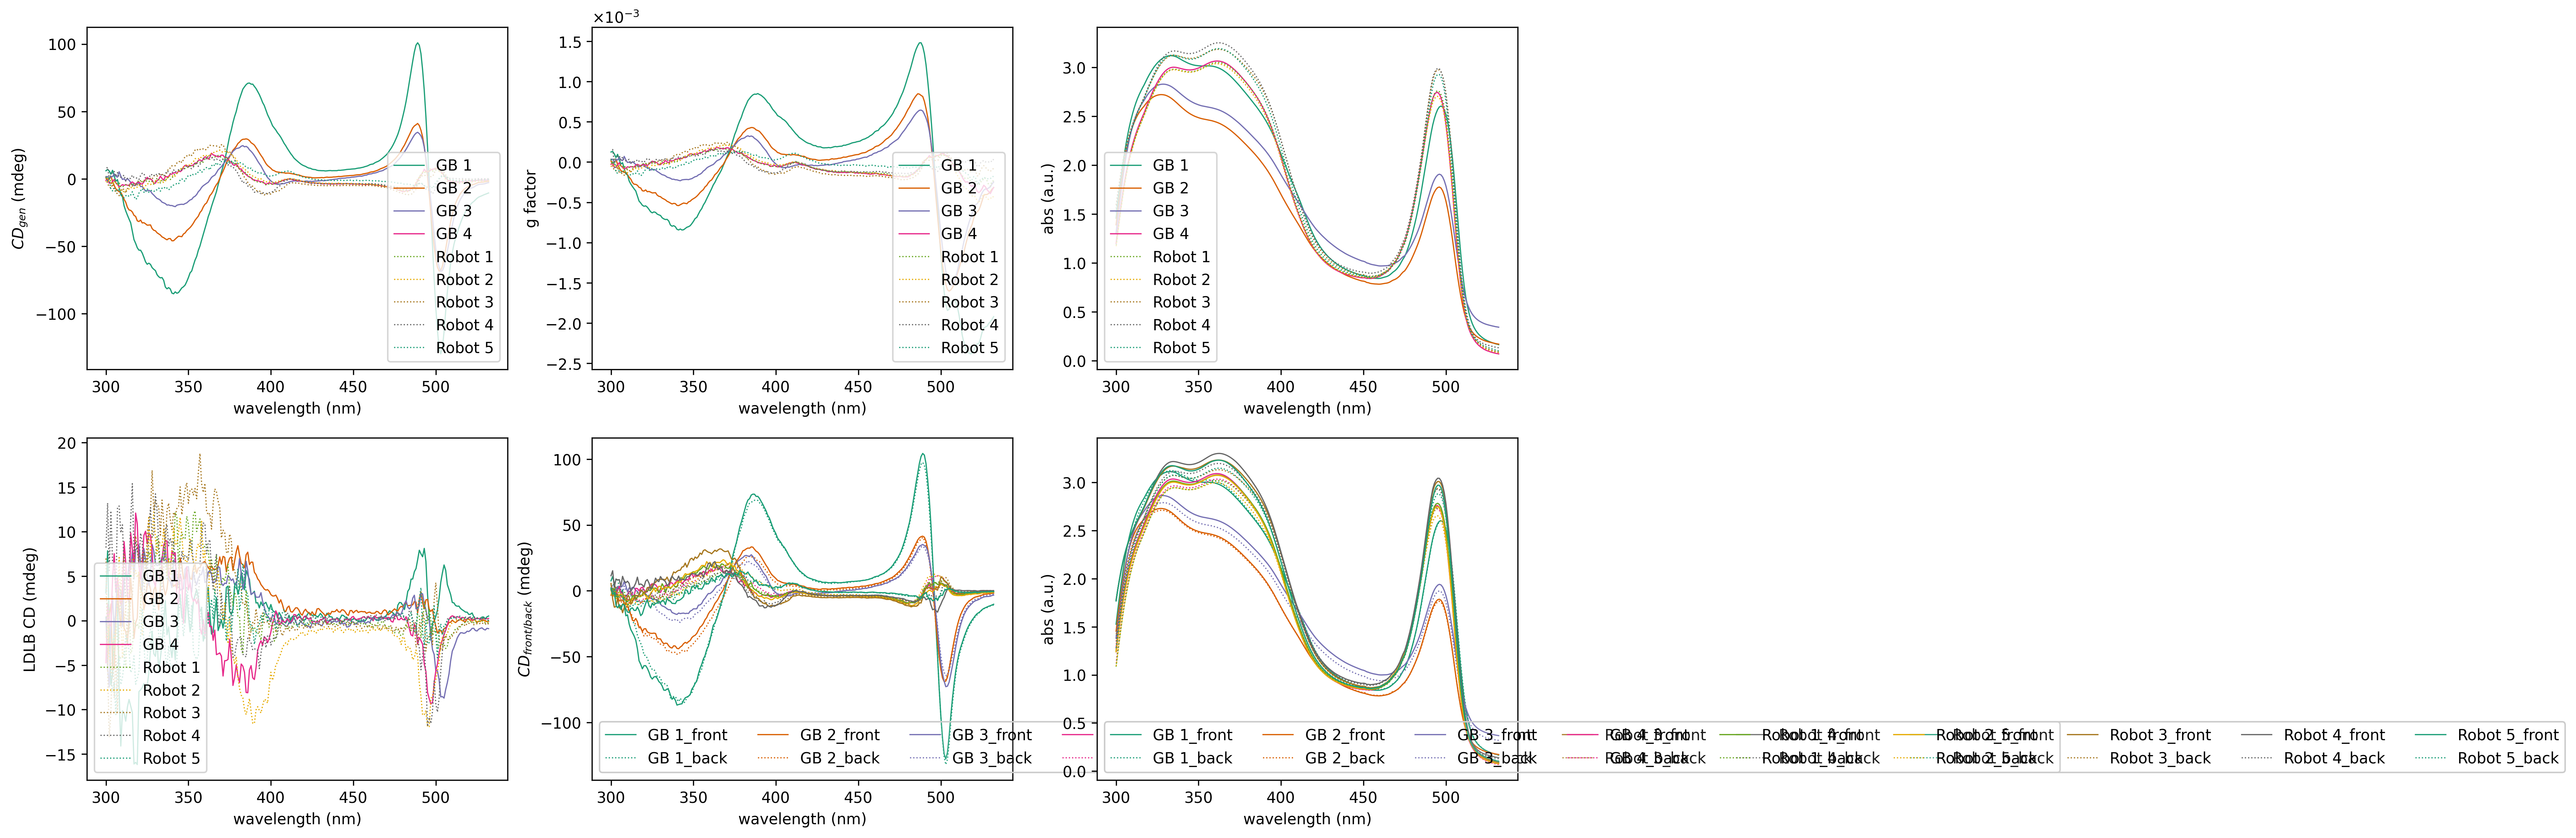

In [ ]:
# Set up color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    "color", plt.colormaps.get_cmap("Dark2").colors
)

# fig, ((ax_cd_gen, ax_ldlb), (ax_uv_vis, ax_g_factor), (ax_cd, ax_uv_vis_fb)) = plt.subplots(nrows=2, ncols=3, figsize=(17, 10), dpi=300, layout="tight")
fig, ((ax_cd_gen, ax_g_factor, ax_uv_vis), (ax_ldlb, ax_cd, ax_uv_vis_fb)) = (
    plt.subplots(nrows=2, ncols=3, figsize=(17, 9), dpi=300)
)

# Plot single-column data using refactored functions
plot_single_column_data(ax_cd_gen, df, "gen_CD_", ylabel="$CD_{gen}$ (mdeg)")
plot_single_column_data(ax_ldlb, df, "ldlb_CD_", ylabel="LDLB CD (mdeg)")
plot_single_column_data(ax_uv_vis, df, "abs_", ylabel="abs (a.u.)")
plot_single_column_data(
    ax_g_factor, df, "g_factor_", ylabel="g factor", scientific_notation=True
)

# Plot front/back paired data using refactored functions
plot_front_back_pairs(ax_cd, df, common_cols, "CD", ylabel="$CD_{front/back}$ (mdeg)")
plot_front_back_pairs(ax_uv_vis_fb, df, common_cols, "abs", ylabel="abs (a.u.)")

# Final layout and save
fig.tight_layout(pad=1.0, w_pad=0.3, h_pad=0.3)
fig.savefig(Path(data_dir, f"{data_dir.stem}.jpg"))

In [2]:
from pathlib import Path
from pprint import pprint

data_dir = Path(r"G:\My Drive\LPS\20250721_S_MeOMBAI_prestudy_3\CD")

txt_files = sorted(list(Path(data_dir).glob("*.txt")))

# txt_files = [
#     txt_file for txt_file in txt_files if int(txt_file.stem.split("-")[-1]) < 7
# ]

txt_files = [ txt_file for txt_file in txt_files ]

pprint(txt_files)

[WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-1.txt'),
 WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-10.txt'),
 WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-11.txt'),
 WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-12.txt'),
 WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-13.txt'),
 WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-14.txt'),
 WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-15.txt'),
 WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-16.txt'),
 WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-17.txt'),
 WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-2.txt'),
 WindowsPath('G:/My Drive/LPS/20250721_S_MeOMBAI_prestudy_3/CD/S_MeOMBAI_3_back-3.txt'),
 WindowsPath(

In [3]:
import pandas as pd
import shutil


def rename_file(filename):
    """Create a renamed copy of files from S_MeOMBAI_2_{front|back}_2-{num} to S_MeOMBAI_2_{front|back}-{num+6}."""
    stem = filename.stem
    if "_2-" in stem:
        parts = stem.split("_2-")
        base = parts[0]
        num = int(parts[1])
        new_num = num + 6
        new_stem = f"{base}-{new_num}"
        new_filename = filename.with_stem(new_stem)
        if new_filename.exists():
            print(f"File '{new_filename.name}' already exists. Skipping copy.")
            return new_filename

        shutil.copy(filename, new_filename)
        print(f"Copied '{filename.name}' to '{new_filename.name}'")

        return new_filename
    return filename


dfs = []
common_cols = set()
for txt_file in txt_files:
    txt_file = rename_file(txt_file)

    if "front" in txt_file.stem:
        get_col = lambda col: f"front_{col}_{txt_file.stem.replace('_front', '')}"
    elif "back" in txt_file.stem:
        get_col = lambda col: f"back_{col}_{txt_file.stem.replace('_back', '')}"
    else:
        raise ValueError(
            f"File {txt_file} does not contain 'front' or 'back' in its name."
        )

    common_cols.add(txt_file.stem.replace("_front", "").replace("_back", ""))

    df = pd.read_csv(
        txt_file,
        sep="\t",
        names=["wavelength", get_col("CD"), get_col("HT"), get_col("abs")],
        skiprows=3,
        # nrows=400,
    )
    df = df.set_index("wavelength")
    # df = df[df.index < 550]
    # df = df[df.index > 470]
    dfs.append(df)

df = pd.concat(dfs, axis=1)

for common_col in sorted(common_cols):
    df[f"gen_CD_{common_col}"] = (
        df[f"front_CD_{common_col}"] + df[f"back_CD_{common_col}"]
    ) / 2
    df[f"ldlb_CD_{common_col}"] = (
        df[f"front_CD_{common_col}"] - df[f"back_CD_{common_col}"]
    )
    df[f"abs_{common_col}"] = (
        df[f"front_abs_{common_col}"] + df[f"back_abs_{common_col}"]
    ) / 2
    df[f"g_factor_{common_col}"] = df[f"gen_CD_{common_col}"] / (
        df[f"abs_{common_col}"] * 32980
    )

from pprint import pprint
pprint(common_cols)


{'S_MeOMBAI_3-1',
 'S_MeOMBAI_3-10',
 'S_MeOMBAI_3-11',
 'S_MeOMBAI_3-12',
 'S_MeOMBAI_3-13',
 'S_MeOMBAI_3-14',
 'S_MeOMBAI_3-15',
 'S_MeOMBAI_3-16',
 'S_MeOMBAI_3-17',
 'S_MeOMBAI_3-2',
 'S_MeOMBAI_3-3',
 'S_MeOMBAI_3-4',
 'S_MeOMBAI_3-5',
 'S_MeOMBAI_3-6',
 'S_MeOMBAI_3-7',
 'S_MeOMBAI_3-8',
 'S_MeOMBAI_3-9'}


C:\Users\yrliu98\AppData\Local\Temp\ipykernel_26492\1704277898.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"abs_{common_col}"] = (
C:\Users\yrliu98\AppData\Local\Temp\ipykernel_26492\1704277898.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"g_factor_{common_col}"] = df[f"gen_CD_{common_col}"] / (


In [4]:
def plot_single_column_data(
    ax,
    df,
    column_prefix,
    xlabel="wavelength (nm)",
    ylabel="",
    scientific_notation=False,
    lw=0.8,
    get_linestyle=None,
    get_label=None,
    get_color=None,
    legend_kwargs=dict(),
):
    """Plot single column data with consistent styling.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axis to plot on
    df : pandas.DataFrame
        DataFrame containing the data
    column_prefix : str
        Prefix to filter columns
    xlabel, ylabel : str
        Axis labels
    scientific_notation : bool
        Whether to use scientific notation on y-axis
    lw : float
        Line width
    get_linestyle : callable, optional
        Function that takes label as argument and returns linestyle string.
        If None, uses default solid line.
    get_label : callable, optional
        Function to generate label from column name.
        If None, uses column name as is.
    get_color : callable, optional
        Function to generate color for the plot lines. If None, uses matplotlib's default color cycle.
    legend_kwargs : dict
        Additional keyword arguments to pass to ax.legend()
    """

    if get_linestyle is None:
        get_linestyle = lambda label: "-"

    if get_label is None:
        get_label = lambda x: x

    if get_color is None:
        get_color = lambda label: None

    for col in sorted([c for c in df.columns if c.startswith(column_prefix)], key=lambda x: get_label(x)):
        df_to_plot = df[[col]].dropna()
        label = get_label(col)
        linestyle = get_linestyle(label)
        color = get_color(label)
        ax.plot(
            df_to_plot.index,
            df_to_plot[col],
            label=label,
            lw=lw,
            linestyle=linestyle,
            color=color,
        )

    ax.legend(**legend_kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if scientific_notation:
        ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0), useMathText=True)


def plot_front_back_pairs(
    ax,
    df,
    common_cols,
    data_type,
    xlabel="wavelength (nm)",
    ylabel="",
    lw=0.8,
    get_linestyle=None,
    get_label=None,
    get_color=None,
    legend_kwargs=dict(),
):
    """Plot front/back paired data with consistent styling and legend.

    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axis to plot on
    df : pandas.DataFrame
        DataFrame containing the data
    common_cols : set or list
        Common column identifiers
    data_type : str
        "CD" or "abs" for column naming
    xlabel, ylabel : str
        Axis labels
    lw : float
        Line width
    get_linestyle : callable, optional
        Function that takes label as argument and returns linestyle string.
        If None, uses default_linestyle_func.
    get_label : callable, optional
        Function to generate label from column name.
        If None, uses column name as is.
    get_color : callable, optional
        Function to generate color for the plot lines. If None, uses matplotlib's default color cycle.
    """

    def default_linestyle_func(label):
        """Default linestyle function: solid for front, dotted for back."""
        return "-" if label.endswith("_front") else ":"

    if get_linestyle is None:
        get_linestyle = default_linestyle_func

    if get_label is None:
        get_label = lambda x: x

    if get_color is None:
        get_color = lambda label: None

    for col in sorted(common_cols):
        front_col = f"front_{data_type}_{col}"
        back_col = f"back_{data_type}_{col}"

        try:
            front_df_to_plot = df[[front_col]].dropna()
            back_df_to_plot = df[[back_col]].dropna()
        except KeyError:
            print(f"Skipping {col} due to missing front/back columns.")
            continue
        
        label = get_label(col)

        # Front line uses the linestyle function
        front_linestyle = get_linestyle(f"{label}_front")
        front_color = get_color(f"{label}_front")
        front_line = ax.plot(
            front_df_to_plot.index,
            front_df_to_plot[front_col],
            label=f"{label}_front",
            lw=lw,
            linestyle=front_linestyle,
            color=front_color,
        )

        # Back line uses the linestyle function
        back_linestyle = get_linestyle(f"{label}_back")
        back_color = get_color(f"{label}_back")
        # Use color from front line if not specified
        plot_color = back_color if back_color is not None else front_line[0].get_color()
        ax.plot(
            back_df_to_plot.index,
            back_df_to_plot[back_col],
            label=f"{label}_back",
            lw=lw,
            linestyle=back_linestyle,
            color=plot_color,
        )

    # Configure legend with front/back grouping
    handles, labels = ax.get_legend_handles_labels()

    # Create a sorting key that groups front and back labels together
    def sort_key(i):
        base_label = labels[i].replace("_front", "").replace("_back", "")
        is_back = labels[i].endswith("_back")
        return (is_back, base_label)

    order = sorted(range(len(labels)), key=sort_key)

    if legend_kwargs["ncols"] is None:
        legend_kwargs["ncols"] = len(common_cols)

    legend = ax.legend(
        handles=[handles[idx] for idx in order],
        labels=[labels[idx] for idx in order],
        framealpha=0,
        fontsize="small",
        **legend_kwargs,
    )
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 0.1))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Skipping S_MeOMBAI_3-1 due to missing front/back columns.
Skipping S_MeOMBAI_3-10 due to missing front/back columns.
Skipping S_MeOMBAI_3-11 due to missing front/back columns.
Skipping S_MeOMBAI_3-12 due to missing front/back columns.
Skipping S_MeOMBAI_3-2 due to missing front/back columns.
Skipping S_MeOMBAI_3-3 due to missing front/back columns.
Skipping S_MeOMBAI_3-4 due to missing front/back columns.
Skipping S_MeOMBAI_3-5 due to missing front/back columns.
Skipping S_MeOMBAI_3-6 due to missing front/back columns.
Skipping S_MeOMBAI_3-7 due to missing front/back columns.
Skipping S_MeOMBAI_3-8 due to missing front/back columns.
Skipping S_MeOMBAI_3-9 due to missing front/back columns.
Skipping S_MeOMBAI_3-1 due to missing front/back columns.
Skipping S_MeOMBAI_3-10 due to missing front/back columns.
Skipping S_MeOMBAI_3-11 due to missing front/back columns.
Skipping S_MeOMBAI_3-12 due to missing front/back columns.
Skipping S_MeOMBAI_3-2 due to missing front/back columns.
Skipping

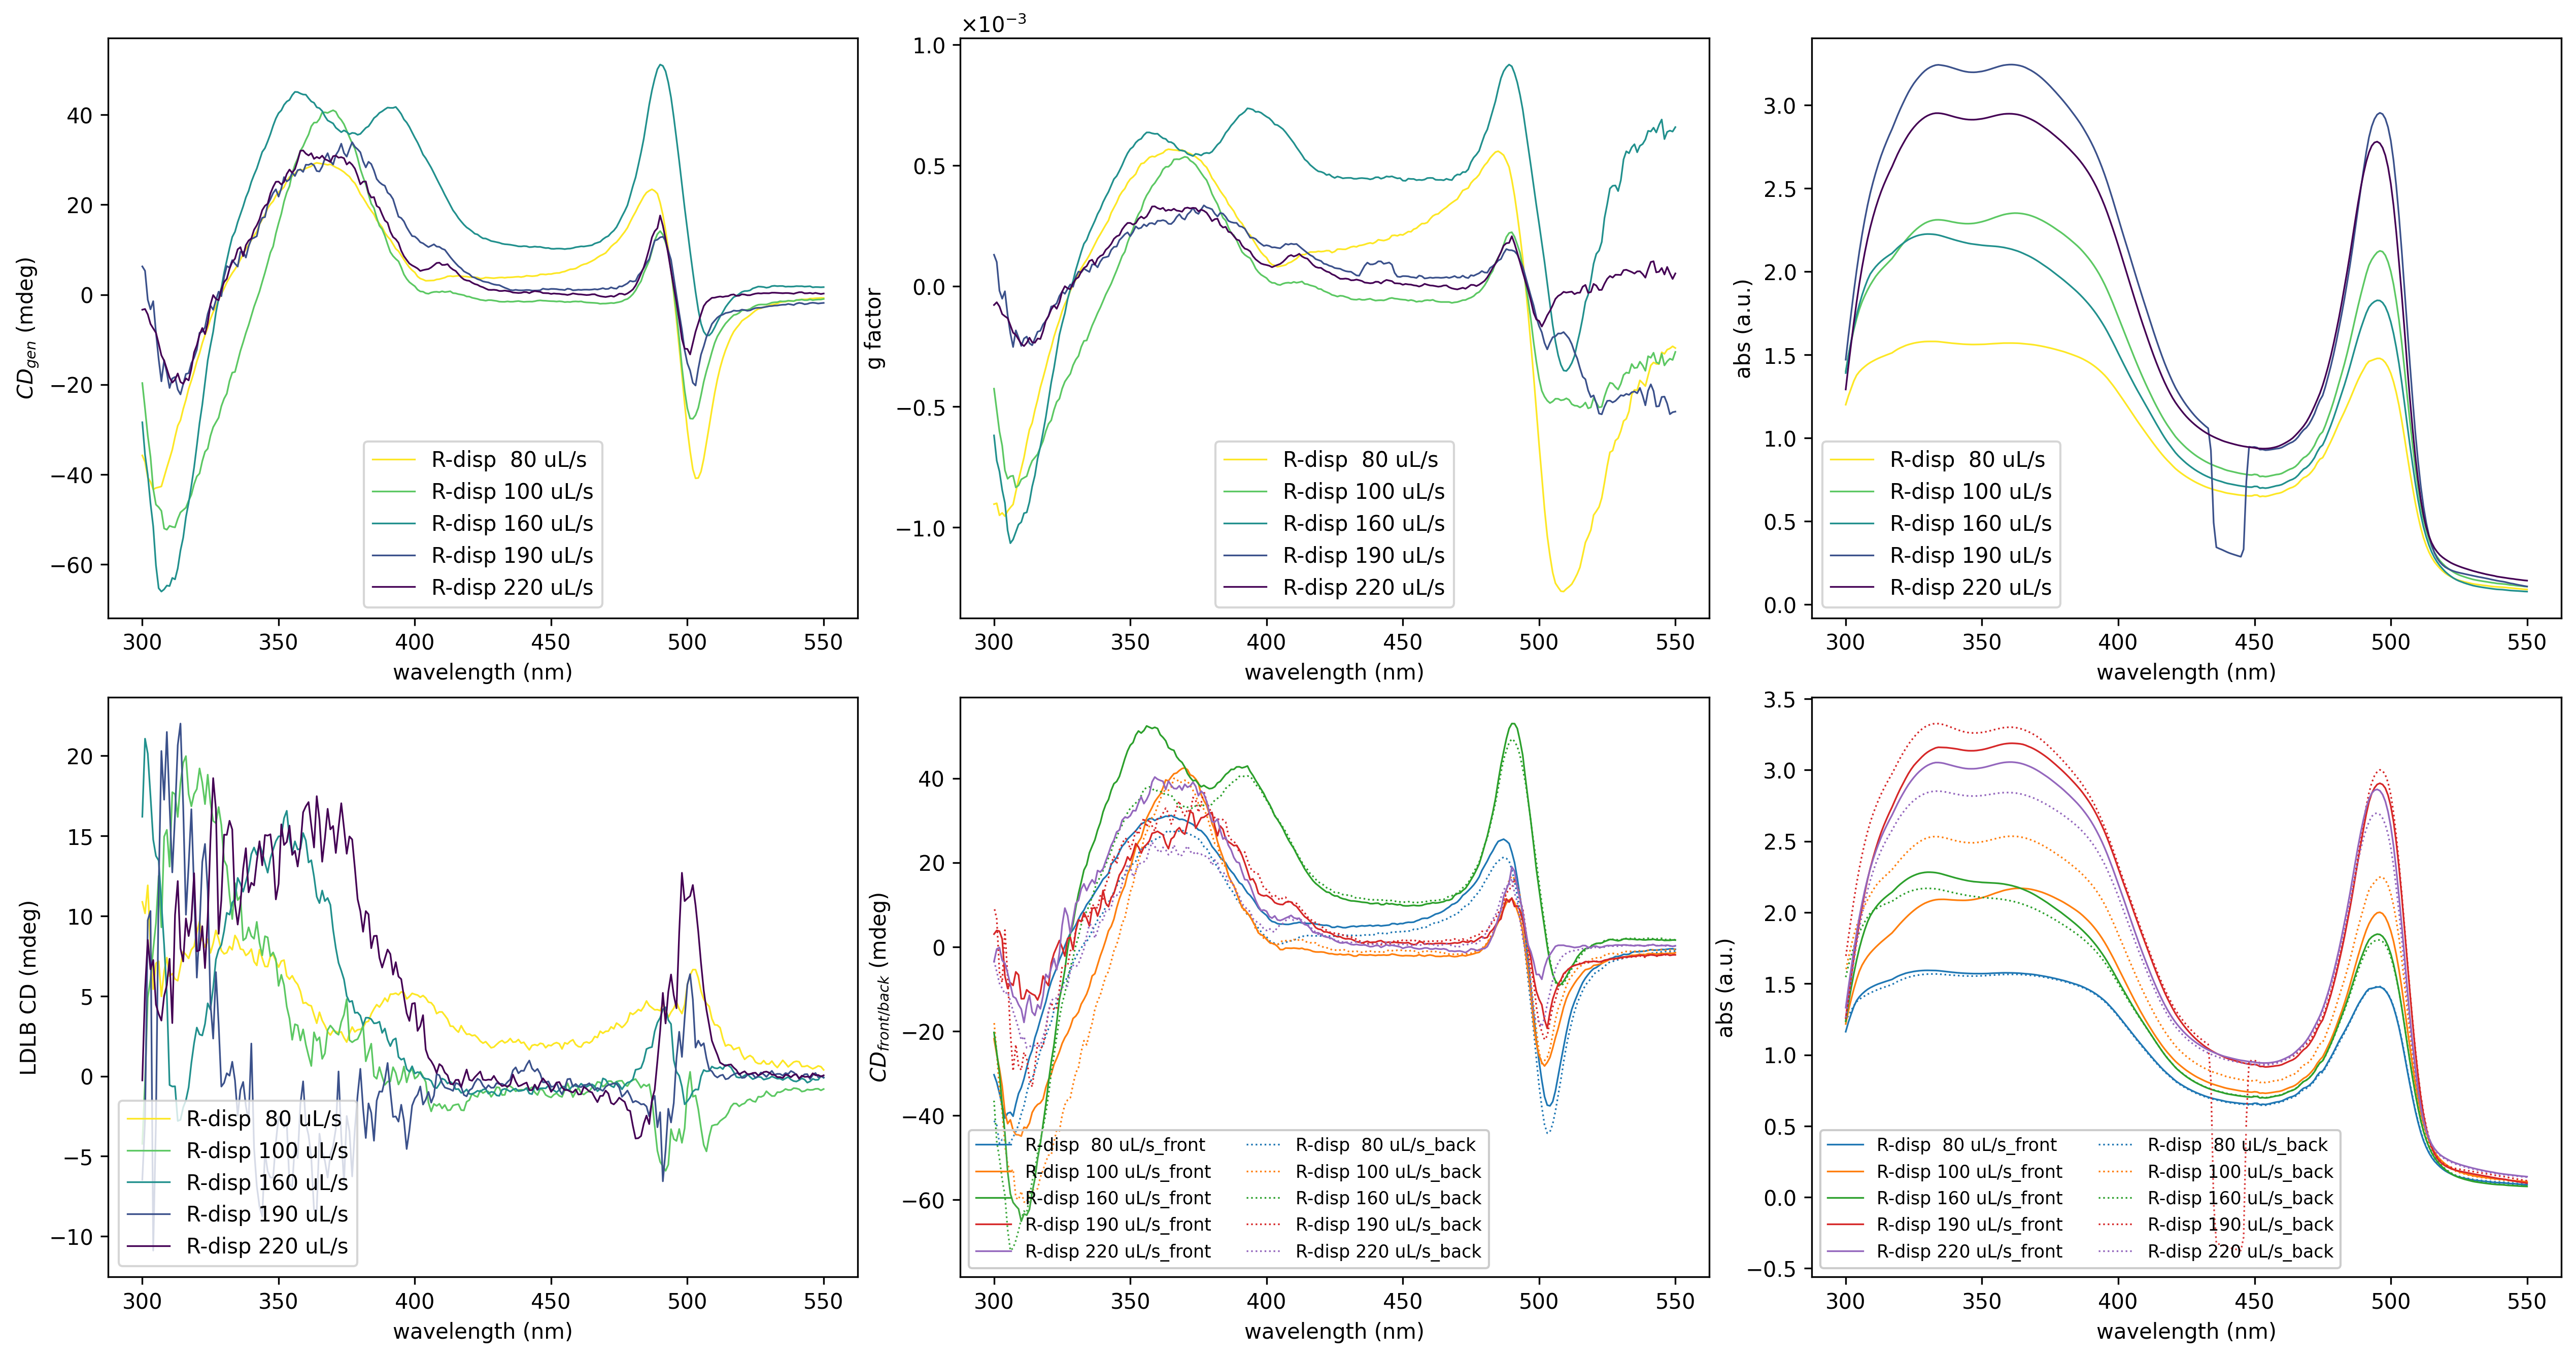

In [20]:
def get_label(_name):
    name = _name.replace("CD_", "").replace("HT_", "").replace("abs_", "")
    sample_number = name.split("-")[-1]
    mapping = {
        "1": "GB-MBAI 1",
        "2": "GB-MBAI 2",
        "3": "GB-MBAI 3",
        "4": "GB 1",
        "5": "GB 2",
        "6": "GB 3",
        "7": "Robot 1",
        "8": "Robot 2",
        "9":  "Robot 3",
        "10": "Robot-MBAI 1",
        "11": "Robot-MBAI 2",
        "12": "Robot-MBAI 3",
        "13": "R-disp  80 uL/s",
        "14": "R-disp 100 uL/s",
        "15": "R-disp 160 uL/s",
        "16": "R-disp 190 uL/s",
        "17": "R-disp 220 uL/s",
    }
    try:
        return mapping[sample_number]
    except KeyError:
        return _name

from plot_helper import get_linestyle_factory, get_color_factory

import numpy as np
get_color = lambda: get_color_factory(colormap="sequential", n=5, cycle_by_prefix=False)

get_linestyle_factory = lambda: lambda x: None


df_original = df.copy()

samples_to_display = ["13", "14", "15", "16", "17"]

columns_to_drop = [ column for column in df_original.columns if column.split("-")[-1] not in samples_to_display ]

df = df_original.drop(columns_to_drop, axis=1)

# fig, ((ax_cd_gen, ax_ldlb), (ax_uv_vis, ax_g_factor), (ax_cd, ax_uv_vis_fb)) = plt.subplots(nrows=2, ncols=3, figsize=(17, 10), dpi=300, layout="tight")
fig, ((ax_cd_gen, ax_g_factor, ax_uv_vis), (ax_ldlb, ax_cd, ax_uv_vis_fb)) = (
    plt.subplots(nrows=2, ncols=3, figsize=(17, 9), dpi=300)
)

# Plot single-column data using refactored functions
plot_single_column_data(
    ax_cd_gen,
    df,
    "gen_CD_",
    ylabel="$CD_{gen}$ (mdeg)",
    get_label=get_label,
    get_linestyle=get_linestyle_factory(),
    get_color=get_color(),
)
plot_single_column_data(
    ax_ldlb,
    df,
    "ldlb_CD_",
    ylabel="LDLB CD (mdeg)",
    get_label=get_label,
    get_linestyle=get_linestyle_factory(),
    get_color=get_color(),
    legend_kwargs={"loc": "lower left"},
)
plot_single_column_data(
    ax_uv_vis,
    df,
    "abs_",
    ylabel="abs (a.u.)",
    get_label=get_label,
    get_linestyle=get_linestyle_factory(),
    get_color=get_color(),
)
plot_single_column_data(
    ax_g_factor,
    df,
    "g_factor_",
    ylabel="g factor",
    get_label=get_label,
    get_linestyle=get_linestyle_factory(),
    get_color=get_color(),
    scientific_notation=True,
)

# Plot front/back paired data using refactored functions
from cycler import cycler

# ax_cd.set_prop_cycle(cycler('color', reversed([plt.cm.viridis(i) for i in np.linspace(0, 1, 6)])))
plot_front_back_pairs(
    ax_cd,
    df,
    common_cols,
    "CD",
    ylabel="$CD_{front/back}$ (mdeg)",
    get_label=get_label,
    legend_kwargs={"ncols": 2, "loc": "lower left"},
)
# ax_uv_vis_fb.set_prop_cycle(cycler('color', reversed([plt.cm.viridis(i) for i in np.linspace(0, 1, 6)])))
plot_front_back_pairs(
    ax_uv_vis_fb,
    df,
    common_cols,
    "abs",
    ylabel="abs (a.u.)",
    get_label=get_label,
    legend_kwargs={"ncols": 2, "loc": "lower left"},
)

# Final layout and save
fig.tight_layout(pad=1.0, w_pad=0.3, h_pad=0.3)
save_path = Path(data_dir, f"{data_dir.stem}_dispense.jpg")
fig.savefig(save_path)
print(f"Saved plot to {save_path}")